I will perform in this notebook the feature selection techniques /if any/, as well as the modelling part. 
To choose the right model and parameters, I am using GridSearchCV technique, with final test set for evaluation.

In [1]:
import pandas as pd
import numpy as np
import math

from math import sqrt
import regex as re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from cycler import cycler

import seaborn as sns
sns.set()

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from textacy import preprocessing
import textacy
from nltk.corpus import stopwords
from nltk.stem import *

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn import metrics
# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

# for the Q-Q plots
import scipy.stats as stats


# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
import joblib

# to determine the p-values with anova
from sklearn.feature_selection import f_classif, f_regression


from sklearn.metrics import r2_score, mean_squared_error
# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

In [2]:
X_train = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/X_train.pkl')
y_train = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/y_train.pkl')
X_test = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/X_test.pkl')
y_test = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/y_test.pkl')

In [3]:
X_train.shape

(3182, 138)

In [4]:
X_test.shape

(359, 138)

# Filter methods

## Constant features removal

In [5]:
sel = VarianceThreshold(threshold=0)

sel.fit(X_train)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [6]:
#Number of features with 0 variance -> those are constant and should be removed
sum(~sel.get_support())

0

## Quasi-constant features

In [7]:
sel = VarianceThreshold(threshold=0.01)  
sel.fit(X_train)  # fit finds the features with low variance

VarianceThreshold(threshold=0.01)

In [8]:
#Number of features with 0 variance -> those are constant and should be removed
quasi_constant = X_train.columns[~sel.get_support()]

len(quasi_constant)

22

There are 22 variables with 1% variance. 

In [9]:
quasi_constant

Index(['latitude', 'longitude', 'free parking street', 'other pet(s)',
       'paid parking premises', 'neighbourhood_cleansed_Bay Village',
       'neighbourhood_cleansed_Hyde Park', 'neighbourhood_cleansed_Mattapan',
       'neighbourhood_cleansed_Longwood Medical Area',
       'neighbourhood_cleansed_Leather District', 'property_type_Villa',
       'property_type_Loft', 'property_type_Boat', 'property_type_Other',
       'property_type_Entire Floor', 'property_type_Guesthouse',
       'bed_type_Couch', 'bed_type_Pull-out Sofa',
       'response_rate_buckets_(40.0, 50.0]',
       'response_rate_buckets_(20.0, 40.0]',
       'response_rate_buckets_(0.0, 20.0]', 'accept_rate_buckets_(0.0, 20.0]'],
      dtype='object')

I will not remove the quasi-constant features. 

In [10]:
# capture feature names

#feat_names = X_train.columns[sel.get_support()]

In [11]:
#remove the quasi-constant features

#X_train = sel.transform(X_train)
#X_test = sel.transform(X_test)

#X_train.shape, X_test.shape

In [12]:
# trasnform the array into a dataframe

#X_train = pd.DataFrame(X_train, columns=feat_names)
#X_test = pd.DataFrame(X_test, columns=feat_names)

#X_test.head()

## Gridsearch CV for the best Random Forest Regressor

In [13]:
#X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
# Create a based model
rf = RandomForestRegressor()

In [34]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap' : [True],
    'max_depth': [40, 60, 80, 90, 100, 110],
    'max_features': ["sqrt","auto"],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 400]
}

In [35]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 1)

In [36]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [40, 60, 80, 90, 100, 110],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 400]},
             verbose=1)

In [37]:
#display the parameters of the best regressor
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

### Final evaluation on test set

In [38]:
y_pred = grid_search.predict(X_test)

In [39]:
r2_score(y_test,y_pred)

0.3134922352807318

In [40]:
x_pred = grid_search.predict(X_train)

In [41]:
r2_score(y_train,x_pred)

0.8113998225749233

### Build the Random Forest Regressor with the best parameters suggested by the GridSearch

In [19]:
rf = RandomForestRegressor(bootstrap=True, max_depth= 100,min_samples_leaf = 3, min_samples_split = 8,n_estimators = 200)

In [20]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=100, min_samples_leaf=3, min_samples_split=8,
                      n_estimators=200)

In [24]:
#get predictions on train set
y_train_rf = rf.predict(X_train)

In [25]:
#r2 score on train set
r2_score(y_train, y_train_rf)

0.8109564201511839

In [21]:
#get predictions on test set
y_pred_rf = rf.predict(X_test)

In [22]:
#r2 on test set
r2_score(y_test, y_pred_rf)

0.3043827685872915

The R2 score that presents an overall metrics for the model, or how much of the variance in the price could be explained with the model, is low - 30.5%. For reference, the R2 score on the training data is 81%. So we see some significant difference between the train and test score, that is possibly due to overfitting on the training set, while the model does not perform well on test /treated as not seen/ data. To calculate the final metrics for root MSE, I will transform back the target variable with exp function /the target variable was the log of the price -> the error metrics are on the logs/

#### Transforming the price predictions of the regression model 

In [70]:
y_test.head()

2294    2.948641
1966    4.605170
2995    3.258097
2616    4.258587
2649    3.663562
Name: price_per_person_log, dtype: float64

In [76]:
#Reversing back the log transformation of the target variable
y_test_normal = np.exp(y_test)
y_train_normal = np.exp(y_train)

In [73]:
y_test_normal.head()

2294     19.08
1966    100.00
2995     26.00
2616     70.71
2649     39.00
Name: price_per_person_log, dtype: float64

In [84]:
y_test_pred_normal = np.exp(y_pred_rf)
y_train_pred_normal = np.exp(y_train_rf)

In [75]:
#Calculating the RMSE based on the original price form  - test set
sqrt(mean_squared_error(y_test_normal,y_test_pred_normal))

43.29387403907735

In [85]:
#Calculating the RMSE based on the original price form - train set 
sqrt(mean_squared_error(y_train_normal,y_train_pred_normal))

12.471040253975692

### Understanding feature importance

To understand which features affect the price, I am using the feature_importances_ built-in function of the Random Forest Regressor, that corresponds to impurity-based feature importance. The higher the value, the more important is the feature to the target variable. 

In [86]:
features = pd.DataFrame(rf.feature_importances_, index = X_train.columns)

In [87]:
features.reset_index().sort_values(by = 0, ascending = False).rename(columns={0:'feature_importance_coef'},inplace=True)

In [88]:
features_1 = features.reset_index().rename(columns={'index':'features',0:'feature_importance_coef'})

In [89]:
features_1[features_1['feature_importance_coef']>0.000000].shape

(130, 2)

In [90]:
features_1[features_1['feature_importance_coef']>0.005]['feature_importance_coef'].sum()

0.8601825603852815

In [91]:
features_1.sort_values(by='feature_importance_coef',ascending=False).head(20)

,features,feature_importance_coef
4,latitude,0.155096
5,longitude,0.142284
10,cleaning_fee,0.051351
102,room_type_Entire home/apt,0.048140
19,reviews_per_month,0.044968
11,number_of_reviews,0.029970
9,security_deposit,0.025863
12,review_scores_rating,0.023876
87,neighbourhood_cleansed_East Boston,0.022493
109,cancellation_policy_flexible,0.020818


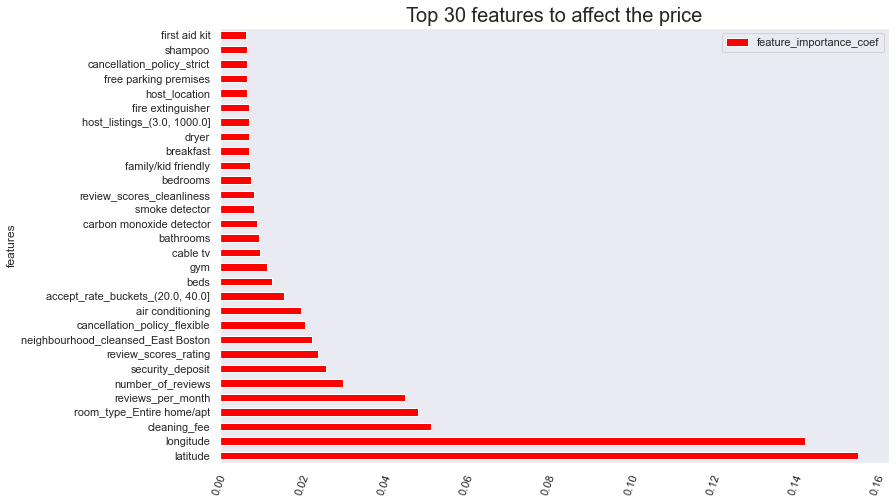

In [100]:
ax = features_1.sort_values(by='feature_importance_coef',ascending=False).head(30).plot(kind='barh', grid=False, x = 'features',y = 'feature_importance_coef',color='red',figsize=(12,8))
plt.xticks(rotation=70)
#ax.set_xticklabels(cal_month.index.strftime('%W'))
plt.ylabel('features')
plt.title('Top 30 features to affect the price', size = 20);
#plt.legend(bbox_to_anchor=(1, 1),title = 'Vendor')

In [77]:
# save the model
filename = '/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/models/random_forest.sav'
joblib.dump(rf, filename)

['/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/models/random_forest.sav']

In [78]:
X_train.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/model/X_train.pkl')
y_train_normal.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/model/y_train.pkl')
X_test.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/model/X_test.pkl')
y_test_normal.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/model/y_test.pkl')